![datiaperti logo](images/datiaperti_small.png)

# Land Use and Land Cover Classification using a ResNet Deep Learning Architecture

![Sentinel-2](images/Sentinel-2-MSI_overview.jpg)

My goal with this notebook was to test the accuracy of Convolutional Neural Networks to learn the spatial and spectral characteristics of image patches of the Earth surface extracted from satellite images for Land Use and Land Cover (LULC) classification tasks. To achieve my goal I use a transfer learning technique that consists of using a pretrained ResNet CNN architecture [1] and finetune it with the EuroSAT dataset [2], a collection of labelled satellite patch images extracted from the Copernicus Sentinel-2 satellites products. I use the [Fastai](https://www.fast.ai/) deep learning library to write the Python code to train and validate the system, and Google Colab to execute it on a GPU. I have also performed some additional LULC classification tests using new images extracted from the Copernicus Sentinel-2 dataset products through the Sentinel-Hub EO-Browser. In the next four sections I provide some information about the LULC classification task, the Sentinel-2 satellites and their products, the EuroSAT dataset, and the finetuning technique. In the coding sections that follow I describe all the steps required to set up a deep learning architecture to accomplish the LULC task and to assess the accuracy of the results.     

## Land Use and Land Cover (LULC) classification
Land cover indicates the type of surface, such as forest or river, whereas land use indicates how people are using the land. Land cover can be determined by the reflectance properties of the surface. This information is commonly extracted from aerial or satellite digital images whose pixels values represent the solar energy reflected by the Earth's surface in different spectral bands. The class of a land cover at the pixel level can be determined by using some combinations of spectral bands. For instance, vegetation has a stronger reflectance in the near infrared region of the spectrum and can be better observed using bands B7, B8, B8a and B9 of the Sentinel-2 MSI than the bands in the visible region of the spectrum, B4, B3, B2 (or RGB). 

![Sentinel-2 MSI spectral bands](images/usgs_spectral_bands.png)

In the visible region, dry grass has a stronger reflectance in band 4 (Red) than in the other two bands B2 and B3 (blue and green). Classical machine learning algorithms such as Random Forests or Support Vector Machine are used to improve the accuracy of the classification. On the other hand, spectral data at the pixel level alone cannot provide information about the land use and a patch image has to be considered in its entirety to infer its use. Often also additional information is required to disambiguate among all the possible uses of a land. Different classification systems have been developed over the years whose goal is to define a taxonomy of land covers and land use. One such classification system is the CORINE land cover nomenclature [3] that contains 44 classes. CORINE is a land cover inventory performed every 6 years by the Copernicus Land Monitoring Service to monitor the changes in land use and land cover over the European continent. The maps produced by CORINE are based on the Sentinel-2 images classified at the pixel level according to the nomenclature and on information available from national cadastre. Since the availability of deep learning algorithms for computer vision, researchers have been developing models to perform LULC tasks, to be used at any time that new images are available and without using information from cadastre that might be expensive, not always up to date or not publicly available.      

## The Copernicus Sentinel-2 satellites
The Copernicus [Sentinel-2](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-2) constellation is based on two identical satellites for earth observation, launched and operated by the European Space Agency (ESA). Each satellite flights on a Sun synchronous polar orbit at 786 km altitude, 180° apart from each other so that the same area can be revisited every 5 days. Both satellites carry a high spatial resolution multispectral imager (MSI) with a 290 km swath that can collect the solar energy reflected by the Earth surface in 13 spectral bands, from the visible to the near-infrared spectral range. The spatial resolution ranges from 10 m per pixel (B2, B3, B4, and B8 bands) down to 60 m per pixel. The ESA processes the raw data for radiometric calibration, orthorectification, atmospheric correction and georeferencing, and delivers the processed images as Level-1C (L1C) and Level-2A (L2A) [data products](https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-2/data-products). Both products are delivered as 100 km x 100 km tiles in UTM/WGS84 projection. L1C products are not processed for atmospheric correction and are described as Top-Of-Atmosphere reflectance data, while L2A products have received atmospheric correction and are described as Bottom-Of-Atmosphere reflectance data. L1C and L2A products can be obtained under an open access license from the [Copernicus Open Access Hub](https://scihub.copernicus.eu/dhus/#/home) or from other providers such as [Sentinel-Hub](https://apps.sentinel-hub.com/eo-browser/).

## The EuroSAT dataset
The EuroSAT dataset was created at the Deutsches Forschungszentrum für Künstliche Intelligenz ([DKFI](https://www.dfki.de/web/)). The images were extracted from the Sentinel-2A L1C products covering cities in 34 European countries all over a year. The dataset consists of two subsets: RGB and multispectral. Each dataset contains 27000 images divided in 10 classes with 2000 to 3000 images per class. The classes defined to label the images are a subset of those defined in CORINE: Pasture, HerbaceousVegetation, Industrial, AnnualCrop, Residential, PermanentCrop, Highway, SeaLake, Forest, River. The RGB dataset contains images covering the three bands in the visible region of the spectrum (RGB colors). The multispectral dataset contains images covering all the 13 specral bands available from the MSI sensor of the Sentinel-2 satellites. The size of each patch image is 64x64 pixels with 10 m resolution. In this notebook I use only the RGB dataset.     


## Finetuning a pretrained ResNet architecture
A Convolutional Neural Network that can learn how to distinguish different types of land covers, where geometries and reflectance properties can be mixed in many different ways, requires an architecture with many layers to achieve a good accuracy. Such architectures are expensive to train from scratch in terms of amount of labeled data needed for training, and also in terms of time and computing resources. It is nowadays normal practice in computer vision to reuse a model that has been pretrained on a different but large set of examples, such as ImageNet, and finetune the pretrained model with data that is specific to the task at hand, in our case LULC classification. Finetuning is a transfer learning technique in which the parameters of a pretrained neural network architecture are updated using the new data. I will use the ResNet50 architecture, pretrained on the ImageNet dataset, as suggested in the EuroSAT paper. I will use the fastai deep learning library to implement all the functions required in this notebook. Fastai is a high level library that leverages the underlying PyTorch machine learning framework.   

## Prepare the development environment
I use Google Colab for development and to test the code using the GPUs that are provided free of charge. The machines available in Google Colab come with an old version of the fastai library that does not support the functions and classes that I will be using and must be updated. I use fastai version 2.5.1 but any other later version should also work fine. In order to install the latest fastai library execute the following command and then restart the runtime.

In [ ]:
!pip install fastai==2.5.1

In [ ]:
import fastai
print(fastai.__version__)

2.5.1


## Download the EuroSAT RGB dataset
I download the EuroSAT RGB images from the DKFI website. The images are compressed in a zip file and divided in 10 folders named after the classes defined for the classification task

In [ ]:
from fastai.vision.all import *
path = untar_data('http://madm.dfki.de/files/sentinel/EuroSAT.zip')

In [ ]:
Path.BASE_PATH = path
path.ls()

(#10) [Path('Forest'),Path('HerbaceousVegetation'),Path('AnnualCrop'),Path('PermanentCrop'),Path('River'),Path('Industrial'),Path('Highway'),Path('Pasture'),Path('Residential'),Path('SeaLake')]

Let's see one image in the PermanentCrop folder

In [ ]:
fname = (path/"PermanentCrop").ls()[0]
fname

Path('PermanentCrop/PermanentCrop_1622.jpg')

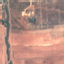

In [ ]:
img = Image.open(fname)
img

We can use regular expression to extract the label from the file name

In [ ]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['PermanentCrop']

## Define the DataLoaders, the test and validation set, and the transformations to be applied
The fastai library provides classes and functions to specify the type of example data (images, text files, tabular data), which transformations must be applied on them (e.g. resizing, cropping), how to find the images in the file system, how to extract their labels (classes), and how to split the EuroSAT dataset in a training set and a validation set. We can also artificially increase the number of images using the data augmentation technique. Fastai provides a convenience function that creates more images from the original EuroSAT dataset by applying different transformations such as flipping, rotation, brightness modification and others. I use the fastai default splitting value, 80% for training and 20% for validation. I do not apply any resizing since all the images in EuroSAT used to finetune the pretrained model have the same shape (64x64 pixels). The main step is to transform all the JPG images in PyTorch tensors, i.e. multidimensional float arrays that can be sent in batches to a GPU for computations. The fastai DataBlock class creates batches of images as 4 dimensional tensors for both the training and the validation steps. A batch is a tensor whose dimensions are B x C x H x W where B stands for batch size, C for channels (e.g. the 3 RGB channels), H for height, and W for width. The default batch size for a DataBlock is 64.  

In [ ]:
blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=RandomSplitter(seed=42),  # default random split 80% training, 20% validation
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'), # extracts the label category from the image's folder name 
                 batch_tfms=aug_transforms(mult=2)) # data augmentation (mult multiplies the default transformation values)

In [ ]:
dls = blocks.dataloaders(path)

We can check that the data loader is properly configured

In [ ]:
blocks.summary(path)

Setting-up type transforms pipelines
Found 27000 items
2 datasets of sizes 21600,5400
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/EuroSAT/AnnualCrop/AnnualCrop_2377.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=64x64
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/EuroSAT/AnnualCrop/AnnualCrop_2377.jpg
    applying partial gives
      AnnualCrop
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(0)

Final sample: (PILImage mode=RGB size=64x64, TensorCategory(0))


Found 27000 items
2 datasets of sizes 21600,5400
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipe

We show some of the pictures in one batch with their labels (e.g. 5 images out of 64 contained in a batch)

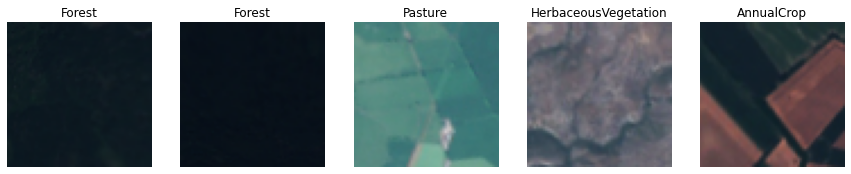

In [ ]:
dls.show_batch(nrows=1, ncols=5)

## Data augmentation
Additional images have been already created in the previous step from the original ones by using the data augmentation technique implemented by the fastai aug_transforms() convenience function. Here I show the images that are created from one example.

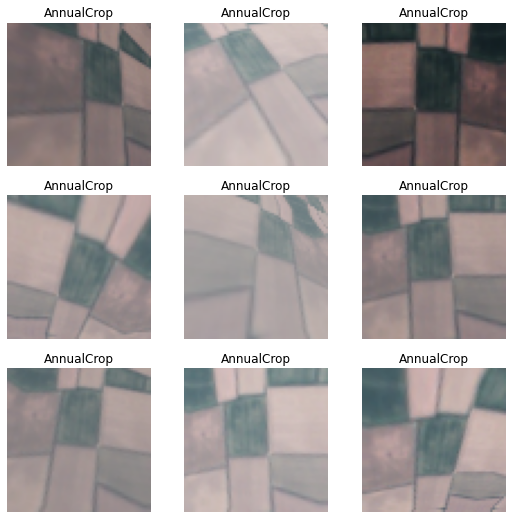

In [ ]:
blocks = blocks.new(batch_tfms=aug_transforms(mult=2.0))
dls = blocks.dataloaders(path)
dls.train.show_batch(nrows=3, unique=True)

## Setup the ResNet50 ConvNet pretrained architecture
Now we select the pretrained architecture to be finetuned using the EuroSAT dataset and the metric we want to use to check whether our model achieves our expectations. In this case we use the accuracy as a metric, that can be simply computed from the error rate (accuracy = 1 - error_rate). We use the ResNet50 architecture pretrained with the ImageNet dataset as in the EuroSAT paper. The ResNet50 CNN architecture contains a sequence of blocks of 3 convolutional layers each, for a total of 50 layers. 

![ResNet bottleneck block](images/resnet_bottleneck_building_block.png)

Each block contains a shortcut connection from the input to the output so that it learns the difference between them, that is the residual. This architectural choise allows to avoid the degradation problem that affects other architectures with many convolutional layers. As said before, a deep architecture is required to learn many complex features from data. Another advantage of the ResNet50 architecture is that the number of parameters don't depend on the size of the images. The number of channels, also known as features maps, and their size are always the same at each layer so that the original ResNet50 parameters that have been computed using 224x224 pixels images can be updated during the finetuning process using images of a different size such as the 64x64 pixels images of the EuroSAT dataset. The final layer reduces the tensor to a one dimensional vector of size 10, the number of the classes, that is finally sent to a softmax layer that computes the probabilities of each image to be a member of any of the 10 classes used to classify the EuroSAT images. The fastai convenience function cnn_learner() is used to customize the learning process by setting different hyperparameters such as the optimizer (e.g. Stochastic Gradient Descent), the loss function, the learning rate and many others. A summary of the architecture is shown before starting the finetuning process.

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=accuracy) 
learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 32 x 32   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 16 x 16  
Conv2d                                    16384      False     
BatchNorm2d                               512        True      
ReLU                                                           
__________________________________________

## Finetuning
Now the ResNet50 architecture is loaded with the pretrained parameters and the finetuning process can start. I set the number of epochs to a value that achieves a good enough accuracy without wasting too much time and resources in computations. We can try different numbers of epochs to find the right one. Fastai provides a convenience function that can do the work for us. In an epoch a batch of images is used to compute an average value of the loss and to update the model parameters before using the next batch till all the batches have been used and a new epoch can start.

In [ ]:
learn.fine_tune(20)

epoch,train_loss,valid_loss,accuracy,time
0,0.037002,0.076655,0.977593,01:20


epoch,train_loss,valid_loss,accuracy,time
0,0.032051,0.091576,0.972963,01:33
1,0.027293,0.090757,0.974074,01:33
2,0.035826,0.095880,0.975741,01:33
3,0.045858,0.094616,0.972963,01:33
4,0.055709,0.085280,0.975926,01:33
5,0.056042,0.089228,0.975370,01:33
6,0.062459,0.090753,0.972222,01:32
7,0.065468,0.108102,0.970926,01:33
8,0.047722,0.112933,0.969630,01:33
9,0.042844,0.078812,0.978148,01:33


We have achieved an accuracy close to 98%. The exact value can change slightly anytime we finetune the model. If that level of accuracy is enough for our purpose we can stop here otherwise we can run more epochs, try different learning rates or apply more transformations to further increase the number of images. We can plot the accuracy of the finetuned model relative to the number of epochs.

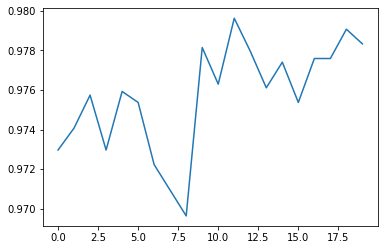

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));

## Model evaluation
We want to understand what is the accuracy of our model in separating images that belong to different classes. For example, it is known that the spectral response of rivers (turbid water) and roads is pretty similar in the visible part of the spectrum as they absorb most of the solar radiation, and seen from a long distance within a patch of 640 m x 640 m a river and a highway might be confused. So we will not be surprised if some images of rivers and roads may be misclassified, that is, an image of a river may be interpreted as an image of a road and vice versa by our model. Also, the distinction between Pasture, Permanent Crop, Annual Crop or Herbaceous Vegetation may not be so clear using only the three RGB bands so we can expect a certain level of misclassifications among these classes as well. We plot the confusion matrix using the validation data to check for which classes there have been misclassifications.

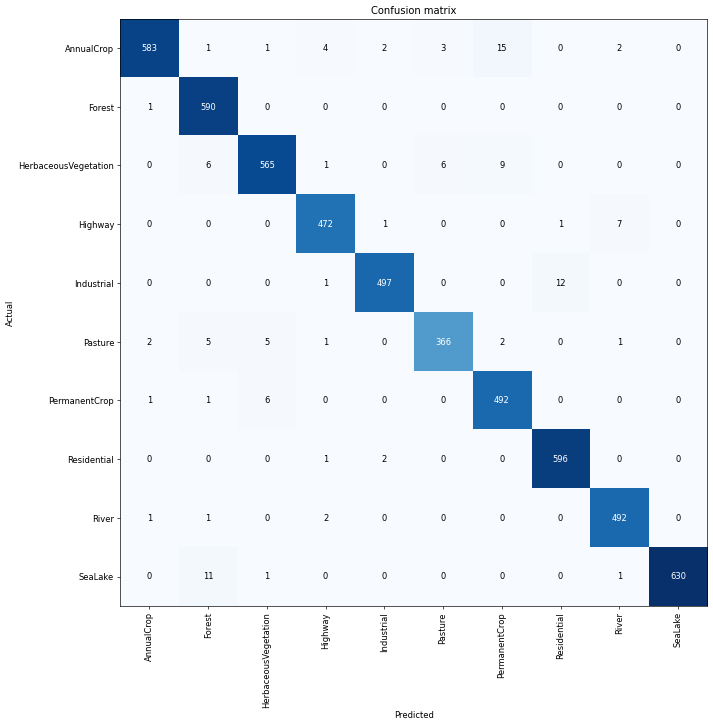

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

We can select the classes that have a minimum number of misclassifications

In [ ]:
interp.most_confused(min_val=5)

[('AnnualCrop', 'PermanentCrop', 15),
 ('Industrial', 'Residential', 12),
 ('SeaLake', 'Forest', 11),
 ('HerbaceousVegetation', 'PermanentCrop', 9),
 ('Highway', 'River', 7),
 ('HerbaceousVegetation', 'Forest', 6),
 ('HerbaceousVegetation', 'Pasture', 6),
 ('PermanentCrop', 'HerbaceousVegetation', 6),
 ('Pasture', 'Forest', 5),
 ('Pasture', 'HerbaceousVegetation', 5)]

As we already figured out, most of the misclassifications happen between classes that are related to the vegetation. Also for rivers and highways some misclassifications are reported. Still the great majority of classifications for each class are correct.

## Save and export the model's finetuned parameters
We can save the finetuned model parameters in case we want to use them in an application. 

In [ ]:
learn.export('eurosat_model.pkl')

In [ ]:
learn_inf = load_learner('eurosat_model.pkl')

## A minimalist application
Once we have achieved the accuracy that we wanted, we can use our finetuned model with new images, for example extracted from the Sentinel-2 products available from Sentinel-Hub. I have extracted some images of patches of land, of the same size as those used to finetune the model (64x64 pixels). They are available in a separate folder. The new images were extracted manually from Sentilel-2 L1C products using the Sentinel-Hub [EO-Browser](https://www.sentinel-hub.com/explore/eobrowser/). An image can be uploaded so that we can see what are the probabilities that it is a member of any of the 10 EuroSAT classes. As an example I use two images from the exact same patch of land from Mesero (Lat. = 45.487971, Lon. = 8.849979), close to Milan, taken two years apart from each other to show how the application can be used to detect changes in land cover and use. 



 


The 1st image of the area was taken in July 2019 and shows a land that is mostly covered by crops ('Permanent Crop' or 'Annual Crop') but also contains a highway at its bottom.

In [ ]:
from fastai.vision.widgets import *
btn_upload1 = widgets.FileUpload()
btn_upload1

FileUpload(value={}, description='Upload')

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
img1 = PILImage.create(btn_upload1.data[-1])
with out_pl: display(img1)
out_pl

Output()

The probabilities computed by our model for the 1st image (I show only the two highest values) are:

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img1)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: Highway; Probability: 0.9980')

In [ ]:
probs

tensor([4.8410e-04, 1.3392e-06, 1.5634e-04, 9.9796e-01, 1.9808e-04, 1.3962e-04,
        8.8622e-04, 4.6300e-05, 1.1766e-04, 1.2730e-05])

The 2nd image was taken in August 2021 and shows an industrial building and still the same highway as in 2019.

In [ ]:
btn_upload2 = widgets.FileUpload()
btn_upload2

FileUpload(value={}, description='Upload')

In [ ]:
out_pl.clear_output()
img2 = PILImage.create(btn_upload2.data[-1])
with out_pl: display(img2)
out_pl

Output()

The probabilities for the 2nd image (2021) are:

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img2)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: Industrial; Probability: 0.7301')

In [ ]:
probs

tensor([2.8591e-04, 3.4131e-06, 1.4427e-04, 2.6680e-01, 7.3014e-01, 3.1067e-05,
        1.4392e-04, 3.6543e-04, 2.0304e-03, 5.0807e-05])

The model has been able to detect the change of land cover even if the presence of objects of two different classes, i.e. crop and highway in the 1st image and industrial building and highway in the 2nd image may have decreased the confidence of the model. If you use the model with the same hyperparameters and number of epoch you should see a similar result with some slightly difference in the probabilities.

## Conclusion
Thanks to the fastai deep learning library it took less than 1 hour to set up the code, finetune the ResNet50 architecture with the EuroSAT RGB dataset for 20 epochs and also perform some tests using new images extracted from the Sentinel-2 products. We have seen that the performances for an LULC task are already quite good but there is certainly room for improvements. The next step is to use the EuroSAT multispectral dataset with the complete set of the Sentinel-2 MSI 13 spectral bands to see whether it helps in better separating the classes related to crop, pasture and forest where the bands in the Near Infrared (NIR) show a stronger reflectance from vegetation than the visible bands.

## References
1. [He K. et al. - Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
2. [Helber P. et al. - EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification](https://arxiv.org/abs/1709.00029) 
3. [Copernicus Land Monitoring Service - CORINE Land Cover User Manual](https://land.copernicus.eu/user-corner/technical-library/clc-product-user-manual)
